In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import *
import seaborn as sns
import warnings
import random
from numpy import *
from sklearn.metrics import accuracy_score
import math
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.mixture import GaussianMixture
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
'''
positive_x_range = [1.0,7.0]
positive_y_range = [3.0,12.0]

negative_x_range = [6.0,15.0]
negative_y_range = [2.0,9.0]

#Creating the Dataframe
df = pd.DataFrame(columns=['f1', 'f2','Class'])

j = 0
#Positive class
for i in range(30):
    v_f1 = round(random.uniform(positive_x_range[0],positive_x_range[1]),2)
    v_f2 = round(random.uniform(positive_y_range[0],positive_y_range[1]),2)
#     print(v_f1,v_f2)
    df.loc[j] = [v_f1,v_f2,'+']
    j += 1

#Negative Class    
for i in range(30):
    v_f1 = round(random.uniform(negative_x_range[0],negative_x_range[1]),2)
    v_f2 = round(random.uniform(negative_y_range[0],negative_y_range[1]),2)
#     print(v_f1,v_f2)
    df.loc[j] = [v_f1,v_f2,'-']
    j += 1
'''

"\npositive_x_range = [1.0,7.0]\npositive_y_range = [3.0,12.0]\n\nnegative_x_range = [6.0,15.0]\nnegative_y_range = [2.0,9.0]\n\n#Creating the Dataframe\ndf = pd.DataFrame(columns=['f1', 'f2','Class'])\n\nj = 0\n#Positive class\nfor i in range(30):\n    v_f1 = round(random.uniform(positive_x_range[0],positive_x_range[1]),2)\n    v_f2 = round(random.uniform(positive_y_range[0],positive_y_range[1]),2)\n#     print(v_f1,v_f2)\n    df.loc[j] = [v_f1,v_f2,'+']\n    j += 1\n\n#Negative Class    \nfor i in range(30):\n    v_f1 = round(random.uniform(negative_x_range[0],negative_x_range[1]),2)\n    v_f2 = round(random.uniform(negative_y_range[0],negative_y_range[1]),2)\n#     print(v_f1,v_f2)\n    df.loc[j] = [v_f1,v_f2,'-']\n    j += 1\n"

In [6]:
# df.to_csv("dataset.csv",header=True,index=False)

In [7]:
df = pd.read_csv("dataset.csv")

In [8]:
df.head()

,f1,f2,Class
0,3.31,4.87,+
1,2.07,7.43,+
2,1.91,9.85,+
3,4.13,3.63,+
4,1.45,4.92,+


In [9]:
df.tail()

,f1,f2,Class
55,12.18,3.93,-
56,7.19,6.75,-
57,9.07,8.46,-
58,14.62,8.46,-
59,13.92,3.22,-


In [10]:
df.sample(10).head(10)

,f1,f2,Class
3,4.13,3.63,+
18,2.14,7.84,+
38,11.05,5.93,-
44,7.77,2.62,-
1,2.07,7.43,+
20,5.28,9.35,+
2,1.91,9.85,+
12,1.63,9.77,+
16,5.77,3.88,+
14,1.09,3.10,+


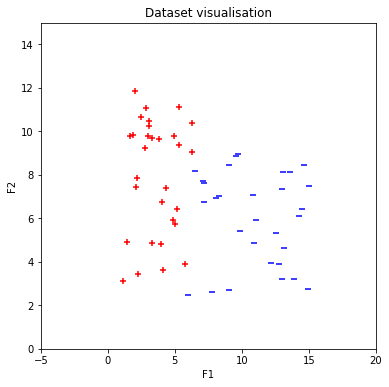

In [12]:
plt.figure(figsize=(6,6))
plt.xlim(-5,20)
plt.ylim(0,15)
plt.title("Dataset visualisation")
plt.xlabel('F1', fontsize=10)
plt.ylabel('F2', fontsize=10)
plt.scatter(df[df['Class']=='+']['f1'],df[df['Class']=='+']['f2'],color='r',marker='+')
plt.scatter(df[df['Class']=='-']['f1'],df[df['Class']=='-']['f2'],color='b',marker='_')

In [13]:
positive_class = df[df['Class']=='+'][['f1','f2']]
negative_class = df[df['Class']=='-'][['f1','f2']]

In [14]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label=='r':
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, c=label,marker='+')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2,c=label,marker='_')
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


In [15]:
gmm_positive = GaussianMixture(n_components=1).fit(positive_class)
gmm_negative = GaussianMixture(n_components=1).fit(negative_class)

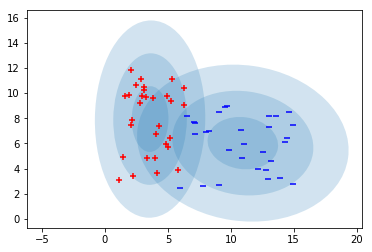

In [16]:
plot_gmm(gmm_positive, np.array(positive_class),label = 'r')
plot_gmm(gmm_negative, np.array(negative_class),label = 'b')

In [17]:
def probabilityFinder(x,mean,covariance,k):
    det = np.linalg.det(covariance)
    normalisingFactor = 1.0/(math.sqrt(math.pow(2*math.pi,k)*det))
    inverseMatrix = np.linalg.inv(covariance)
    vector1 = np.array(x-mean)
    vector2 = np.transpose(vector1)
    factor = math.exp(-0.5 * np.matmul(np.matmul(vector1,inverseMatrix),vector2))
    return normalisingFactor * factor

In [18]:
def class_probability(df,k):
    cnt = 0.0
    p_positive = 0.0
    p_negative = 0.0
    for index, row in df.iterrows():
        temp_pos = 0.0
        temp_neg = 0.0
        for i in range(k):
            temp_pos += (probabilityFinder([row['f1'],row['f2']],gmm_positive.means_[i],gmm_positive.covariances_[i],2))
            temp_neg += (probabilityFinder([row['f1'],row['f2']],gmm_negative.means_[i],gmm_negative.covariances_[i],2))
        p_positive += temp_pos/(temp_pos + temp_neg)
        p_negative += temp_neg/(temp_pos + temp_neg)
        cnt += 1
    return round(p_positive/cnt,3),round(p_negative/cnt,3)


In [19]:
gmm_positive.covariances_[0]

array([[2.13844056, 0.06189933],
       [0.06189933, 6.82873167]])

In [20]:
gmm_positive.means_[0]

array([3.58266667, 7.934     ])

In [21]:
class_probability(df,1)

(0.5, 0.5)

In [22]:

kl_divergence = 0.0
for index, row in df.iterrows():
    temp_pos = (probabilityFinder([row['f1'],row['f2']],gmm_positive.means_[0],gmm_positive.covariances_[0],2)) * class_probability(df,1)[0]
    temp_neg = (probabilityFinder([row['f1'],row['f2']],gmm_negative.means_[0],gmm_negative.covariances_[0],2)) * class_probability(df,1)[1]
    prob_pos = temp_pos/(temp_pos + temp_neg) 
    prob_neg = temp_neg/(temp_pos + temp_neg) 
#     print(prob_pos,prob_neg)
    if(row['Class']=='+'):
        kl_divergence += math.log(1.0/prob_pos,2)
    else:
        kl_divergence += math.log(1.0/prob_neg,2)

In [25]:
print(kl_divergence)

0.002083049712170739


In [26]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

1 5.74196630725205
2 3.181209910293074
3 0.43988235404954285
4 0.4817637905821191
5 0.5722465697862407
6 0.10579798422293678
7 0.10780410775545475
8 0.0006821414541424829
9 0.1051579591665749
10 0.0020965315700819495


<Figure size 432x288 with 0 Axes>

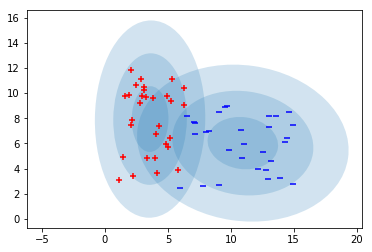

<Figure size 432x288 with 0 Axes>

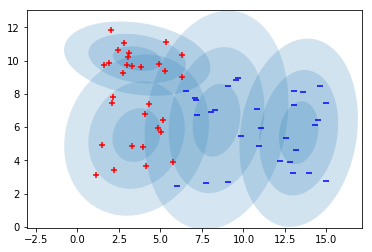

<Figure size 432x288 with 0 Axes>

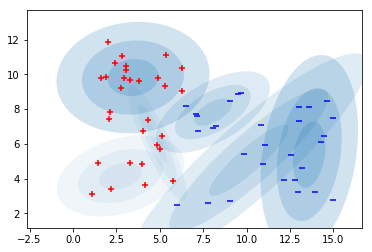

<Figure size 432x288 with 0 Axes>

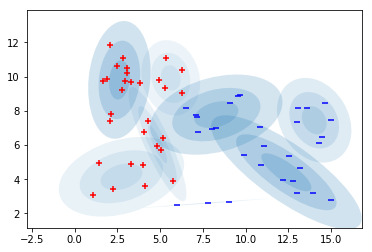

<Figure size 432x288 with 0 Axes>

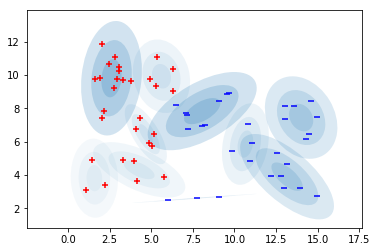

<Figure size 432x288 with 0 Axes>

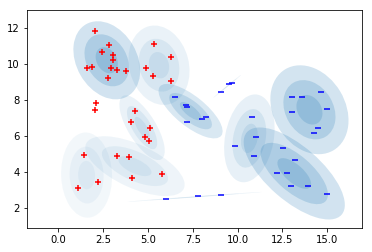

<Figure size 432x288 with 0 Axes>

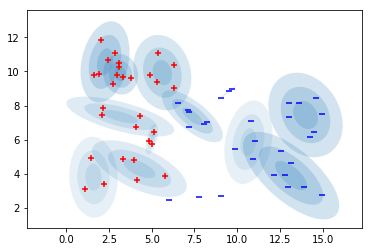

<Figure size 432x288 with 0 Axes>

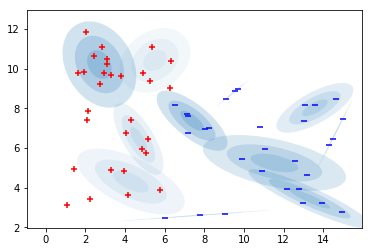

<Figure size 432x288 with 0 Axes>

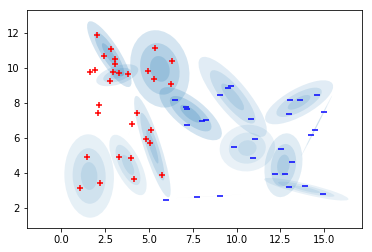

<Figure size 432x288 with 0 Axes>

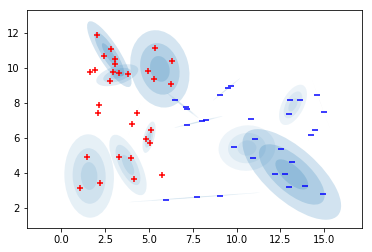

Exception in callback BaseAsyncIOLoop._handle_events(15, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(15, 1)>
Traceback (most recent call last):
  File "/Users/a0m00vn/anaconda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/a0m00vn/anaconda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/Users/a0m00vn/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/a0m00vn/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/a0m00vn/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/a0m00vn/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs

In [28]:
for k in range(1,11):
    plt.figure()
    gmm_positive = GaussianMixture(n_components=k).fit(positive_class)
    gmm_negative = GaussianMixture(n_components=k).fit(negative_class)
    plt.figure()
    plot_gmm(gmm_positive, np.array(positive_class),label = 'r')
    plot_gmm(gmm_negative, np.array(negative_class),label = 'b')
    #class probability
    kl_divergence = 0.0
    for index, row in df.iterrows():
        temp_pos = 0.0
        temp_neg = 0.0
        for i in range(k):
            temp_pos += (probabilityFinder([row['f1'],row['f2']],gmm_positive.means_[i],gmm_positive.covariances_[i],2))
            temp_neg += (probabilityFinder([row['f1'],row['f2']],gmm_negative.means_[i],gmm_negative.covariances_[i],2))
        temp_pos *= class_probability(df,k)[0]
        temp_neg *= class_probability(df,k)[1]
#         print("Positive probability",class_probability(df,k)[0],"Negative probability",class_probability(df,k)[1])
        prob_pos = temp_pos/(temp_pos+temp_neg)
        prob_neg = temp_neg/(temp_pos+temp_neg)
#         print(prob_pos,prob_neg)
        if(row['Class']=='+'):
            kl_divergence += math.log(1.0/prob_pos,2)
        else:
            kl_divergence += math.log(1.0/prob_neg,2)
    print(k,kl_divergence)
    plt.savefig(str(k) +".jpg")